<a href="https://colab.research.google.com/github/olivia-maras/olivia-maras/blob/main/Copy_of_07_WorkingWithLogisticRegressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Logistic Regression in Python**

Credit for the bulk of this notebook goes to Jonathan Stray (https://twitter.com/jonathanstray) via (https://github.com/jstray/lede-algorithms) 

This notebook builds up to logistic regression, that is, fitting a model that predicts the output where there are only two choices.

Throughout we'll be using data on citations for speeding from Massechusets from 2001. This data was originally analyzed by the Boston Globe for their series [Speed Trap: Who gets a ticket, who gets a break?](http://archive.boston.com/globe/metro/packages/tickets/). You can read about their analysis in this [methodology document](http://archive.boston.com/globe/metro/packages/tickets/study.pdf), and get the original data [here](http://archive.boston.com/globe/metro/packages/tickets/warnings.zip).

For a brief period between April and May 2001, the Massachusetts state government recorded both speeding tickets and warnings from officer's paper citations into their database. At that time, both types of citations were written up on the same form, with only a checkbox differentiating between the two. This solves the "denominator problem" that often arises when doing analyses on real-world phenomena: we have data about one part of the situation we want to study (e.g. tickets, police stops &c), but we rarely have data about the population that was _not_ ticketed, stopped, &c., limiting what we can say about potential bias in rates.

From the driver's perspective, a ticket results in a fine that could raise your insurance premium or generate "points" on your license. A warning does neither of those. Having data on both means we can analyze the data to determine what patterns exist, if any, within the populations of drivers who get tickets vs. warnings, especially when the circumstances are similar or the same. 

There is a lot of data about each stop, including the speed, age, race, gender, and home zip code of the driver. The main question is, are some groups more likely to get tickets, and not warnings, than others?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# THIS CODE REQUIRED FOR GOOGLE COLAB
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
# Documentation found here: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# THIS CODE REQUIRED FOR GOOGLE COLAB
# Link to data file stored in Drive: https://drive.google.com/file/d/16OmsgHvqogWutxbte8EiRlEloVuNys32/view?usp=sharing
file_id = '16OmsgHvqogWutxbte8EiRlEloVuNys32' # notice where this string comes from in link above

imported_file = drive.CreateFile({'id': file_id}) # creating an accessible copy of the shared data file
print(imported_file['title'])  # it should print the title of desired file
imported_file.GetContentFile(imported_file['title']) # refer to it in this notebook by the same name as it has in Drive

tickets-warnings.csv


In [ ]:
tw_raw = pd.read_csv('tickets-warnings.csv')


For a complete description of all 57 fields, see the [methodology](http://archive.boston.com/globe/metro/packages/tickets/study.pdf). For our purposes, we are only intersted in the citations for speeding, and most interested in the fields `TYPE` (ticket or warning), `MINORITY`, `SEX`, `AGE`, and `MPHOVER`.

In [ ]:
# only look at the speeding offenses

only_speeding = tw_raw['DESCRIPT'] == 'SPEEDING'
tw = tw_raw[only_speeding].reset_index(drop=True)


# focus only on the columns that interest us
tw=tw[['DATE', 'TYPE', 'AGENCY3','SEX', 'MINORITY', 'AGE', 'MPH','MPHOVER', 'INTOWN']]
tw.head()


,DATE,TYPE,AGENCY3,SEX,MINORITY,AGE,MPH,MPHOVER,INTOWN
0,20010411.0,T,S,M,W,21.0,80.0,15.0,N
1,20010427.0,T,S,M,W,24.0,85.0,20.0,N
2,20010502.0,T,S,M,W,37.0,80.0,30.0,N
3,20010506.0,W,S,M,W,30.0,80.0,15.0,N
4,20010506.0,W,S,F,M,22.0,75.0,10.0,N


Let's start with the total number of minority vs. white drivers

In [ ]:
tw.groupby('MINORITY').count()

,DATE,TYPE,AGENCY3,SEX,AGE,MPH,MPHOVER,INTOWN
MINORITY,,,,,,,,
M,12836,12836,12836,12836,12833,12836,12609,12836
U,1633,1633,1633,1633,1632,1633,1592,1633
W,79275,79275,79275,79275,79262,79275,78071,79275


What fraction of citations were given to minorities?

In [ ]:
12836/(12836+79275)

0.13935360597539925

Is 14% a lot or a little? This is another case where we run into the "denominator problem". We could compare to the minority population of the towns where these stops happened, but would also need to account for things like people driving through. There's also no guarantee drivers in both groups have the same distribution of speeds. 

Insteaed, we're going to compare the probability of getting a warning, as opposed to a ticket, between the groups.

First, let's clean up the data a little but dropping the relatively small (>2%) number of records where the race of the driver is unknown.

In [ ]:
# drop the unknown race entries
# renumber the rows, and don't create a new column

unknown_filter = tw['MINORITY'] != 'U'
tw = tw[unknown_filter].reset_index(drop=True) #drop all rows where race/ethnicity is unknown

In [ ]:
# how many people are in each group? "1" is any non-white driver
sz = tw.groupby(['MINORITY', 'TYPE']).size()
sz

MINORITY  TYPE
M         T        7731
          W        5105
W         T       40126
          W       39149
dtype: int64

In [ ]:
# a crosstab is probably a little easier to read

pd.crosstab(tw.MINORITY, tw.TYPE)

TYPE,T,W
MINORITY,,
M,7731,5105
W,40126,39149


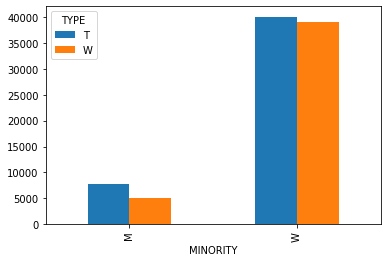

In [ ]:
# let's visualize this as a bar graph

pd.crosstab(tw.MINORITY, tw.TYPE).plot(kind='bar')


In [ ]:
# percent of minority citations which were tickets

minority_ticket_pct = sz['M']['T']/ sum(sz['M'])

print(minority_ticket_pct)


0.6022904331567467


In [ ]:
# percent of non-minority citations which were tickets

white_ticket_pct = sz['W']['T']/ sum(sz['W'])

print(white_ticket_pct)

0.5061620939766636


So even though non-white drivers make up a much smaller proportion of those stopped, we can see off the bat that their ticketing rate is higher than that of white drivers. We can do a visual comparison of this.

In [ ]:
pd.DataFrame([minority_ticket_pct , white_ticket_pct])

Of course, we still have the possibility of confounding factors, so we'll want to look at our other data columns for insight, in order to make sure we're comparing "apples to apples" as much as possible. Some other factors we have that might reasonably influence the ticketing rate are:  `MPHOVER` (how much over the speed limit the driver was), and perhaps age and sex. Legend also has it that traffic cops are harsher to drivers from out of town (`INTOWN` indicates where the driver was from.)

Let's start by comparing histograms of the race and `MPHOVER`.

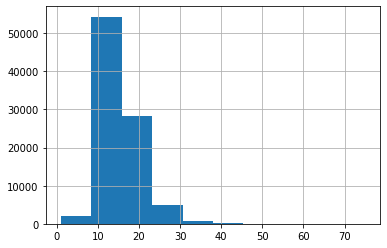

In [ ]:
tw['MPHOVER'].hist()

We've used `MPHOVER` because speed over the limit is probably more interesting than how fast in absolute terms. But checking raw `MPH`, we see a problem with the data: some of the entries don't record the speed! Fortunately, not very many. 

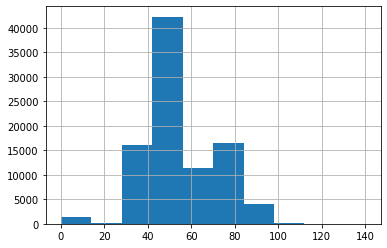

In [ ]:
 # some of these values are zero, which can't be right

 tw['MPH'].hist()

Now let's compare the `MPHOVER` histograms for white and non-white drivers to see if the distributions are different.

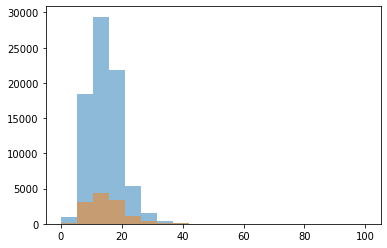

In [ ]:
# need dropna because some rows don't record speed

white_filter = tw['MINORITY'] == 'W'
minority_filter = tw['MINORITY'] == 'M'

white_mph_over = tw[white_filter]['MPHOVER'].dropna()
minority_mph_over = tw[minority_filter]['MPHOVER'].dropna()

# define the bins of the histogram

bins = np.linspace(0,100,20)

# set the transparency to 50% so we can see both simultaneously

plt.hist(white_mph_over, bins, alpha = 0.5)
plt.hist(minority_mph_over, bins, alpha = 0.5)
plt.show()

Still very hard to see, because the scaling is so different. Let's normalize the histograms to display percentages instead of counts.

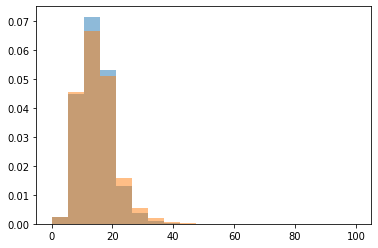

In [ ]:
# the density parameter makes this a percentage, rather than a raw count
plt.hist(white_mph_over, bins, alpha = 0.5, density=True ); 
plt.hist(minority_mph_over, bins, alpha = 0.5, density=True);

Hmm, they look pretty close. The minorities plot has a slightly fatter tail, but not sigificantly. Since the distributions also look *reasonably* "normal" let's take a look at the averages, just to get another sense.

In [ ]:
print(white_mph_over.mean())
print(white_mph_over.median())

15.066798170895723
15.0


In [ ]:
print(minority_mph_over.mean())
print(minority_mph_over.median())

15.575303354746609
15.0


So, only about half a mile an hour difference, on average, and exactly the same median value as well.

As we noted above, there are many other factors that could be contributing to the difference in ticketing rate. Age and sex could be factors. In town or out of town drivers could matter. The `AGENCY` column records whether the stop was made by Massechusets state police, Boston police, or all other police departments, and that could matter both in terms of how the different agencies operate and in terms of who is driving within their jurisdiction. 

For our purposes, bias means that minorities get a ticket more often than white people *when everything else is equal.* Is everything else equal? Let's plot a pile of histograms and take a look.

In [ ]:
# define a function to generate comparative charts of white vs. non-white drivers, based on the column name passed in
def comparehist(colname):
    w = tw[tw['MINORITY']=='W'][colname].dropna()
    m = tw[tw['MINORITY']=='M'][colname].dropna()
    
    if tw[colname].dtype == np.float64:
        # it's numeric, plot a histogram
        bins = np.linspace(0, 100, 20)
        plt.hist(w,bins,alpha=0.5,density=True)
        plt.hist(m,bins,alpha=0.5,density=True)
    else:
        # if not numerical, assume it's categorical and plot a bar chart of value counts normalized to percentages
        wc = w.value_counts()
        wc /= sum(wc)
        plt.bar(wc.index, wc, alpha=0.5)
        mc = m.value_counts()
        mc /= sum(mc)
        plt.bar(mc.index, mc, alpha=0.5)
        
    plt.title(colname)
    plt.show()

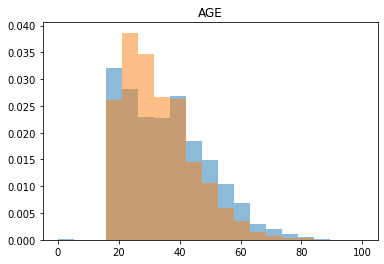

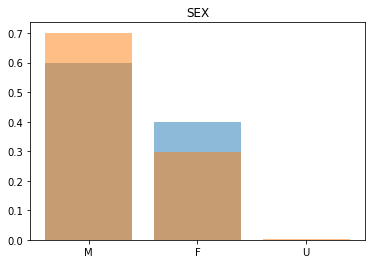

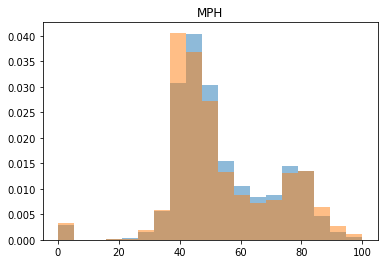

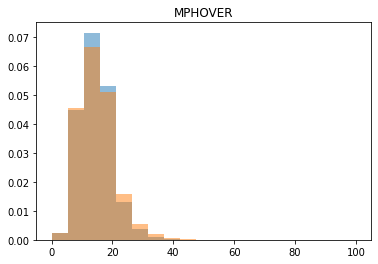

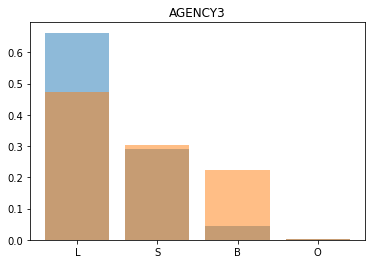

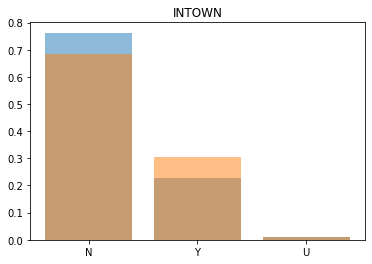

In [ ]:
comparehist('AGE')
comparehist('SEX')
comparehist('MPH')
comparehist('MPHOVER')
comparehist('AGENCY3')
comparehist('INTOWN')


What can we say here? The minority drivers in this sample have more people in their 20s, skew male, are going slightly faster when they're pulled over, are less likely to be stopped by local police and more likely to be stopped by Boston police, and tend to be from "out of town" more often. Any or all of these effects could account for the difference in ticketing rates. There could even be interactions here: suppose Boston police are harder on people who drive more than 10 mph over the limit. These minority drivers are both more commonly in Boston and going faster on average.

### Enter logistic regression
We're going to use regression to try to analyze the relationships between the variables and whether someone gets a ticket. But because the variable we are trying to predict is binary, we'll be using a *logistic* regression. As you'll see below, the process is nearly identical, except that instead of fitting a line to our data, we'll be fitting a curve.

In [ ]:
from sklearn.linear_model import LinearRegression,LogisticRegression

To set up the regression, let's look at a graph of MPH over the limit on the x axis, vs. whether the driver got a ticket on the y axis, represented as 0 or 1. 

In [ ]:
# add a column called 'TICKETED' that is 1 (true) if they got a ticket instead of a warning


# Remove rows where MPH is unknown


In [ ]:
# sort by MPHOVER (makes the plotting below simpler)


In [ ]:
# even though our "y" values are only 0 or 1, we can still put them on a scatter plot, though we get lines instead of clusters


Based on the dots that appear farther to the right for y=1 (BUSTED=True), we migth expect that this data has a general "upward slope." We can use use linear regression to try to fit a trend line to it, but it's not very satisfactory...

In [ ]:
lm = LinearRegression()
lm.fit(x,y)
tw.plot(kind='scatter',x='MPHOVER',y='TICKETED')
plt.plot(x,lm.predict(x),'-',color='m')

Let's apply logistic regression and plot the answer. To interpret the output, we take our normal y=mx+b line but run it through the logistic function.

In [ ]:
# Run the logistic regression (from sklearn) on our data, lm is the model

# Adding the "ravel()" function call in order change the shape of the argument 
# see: https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
lm.fit(x,y.ravel())



# plot original data
tw.plot(kind='scatter',x='MPHOVER',y='TICKETED')

# Now plot the prediction of the fitted model. Does the code look familiar?
m = lm.coef_[0]
b = lm.intercept_
line_y = m*x+b

# define a logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

prediction = logistic(line_y) 
plt.plot(x, prediction, '-', color='m')


We can do the same thing with the `predict_proba` function (though it returns two columns: one is the probability of  FALSE and the other is the probability of TRUE, so we plot only the second column)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y.ravel(), lm.predict(x))

print(cm)
print(lm.score(x, y))


# To get the odds ratio, we use the following formula:
np.exp(lm.coef_)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm,cmap='gray')
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='blue')
plt.show()

### Controlling for other variables

Just like a linear regression, we can feed as many independent variables as we like into logistic regression. And just like linear regression, each coefficient in our logistic regression tells us how much a particular independent variable affects the odds of getting a ticket *if all other variables stay the same.*

In [ ]:
# Code these variables a binary: sex, race, "in town"
tw.SEX = tw.SEX.replace({'M':0,'F':1, 'U':0})
tw.MINORITY = tw.MINORITY.replace({'W':0,'M':1})
tw.INTOWN = tw.INTOWN.replace({'N':0,'Y':1, 'U':0})

# check for NA values
print(tw.isna().sum())

In [ ]:
# remove rows with unknown ages, because there are so few


In [ ]:
# Do a logistic regression on many fields at the same time
fields = ['MPHOVER','MINORITY','SEX', 'AGE', 'INTOWN']
x = tw[fields].values
y = tw[['TICKETED']].values
lm = LogisticRegression() 
lm.fit(x,y.ravel())
       
# print out the odds ratios for each variable
results = pd.DataFrame(np.exp(lm.coef_), columns=fields)
print(results)

In other words, the independent variable that has the greatest impact on whether or not someone receives a ticket is whether or not they are a minority - even moreso than how many MPH over the speed limit they were going when they were stopped. This is the increased odds of getting a ticket if a driver was not white, if all the other independent variables in the model are held equal. 